In [36]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Define the schema for the CSV dataset

csv_path = "Food2.csv"
data = spark.read.csv(csv_path,  header=True)

# Perform operations on the DataFrame
data.show(5)


+------------+-----+--------+-------------+--------------+-----------------+-----------+------------------+--------+-----------+--------------------+--------+-------------+-----+
|review_count|stars|Take-out|GoodFor_lunch|GoodFor_dinner|GoodFor_breakfast|Noise_Level|Takes_Reservations|Delivery|Parking_lot|WheelchairAccessible| Alcohol|WaiterService|Wi-Fi|
+------------+-----+--------+-------------+--------------+-----------------+-----------+------------------+--------+-----------+--------------------+--------+-------------+-----+
|           4|    1|    TRUE|        FALSE|         FALSE|            FALSE|    average|             FALSE|   FALSE|      FALSE|                 N/A|    none|        FALSE|  N/A|
|          20|    1|    TRUE|         TRUE|         FALSE|            FALSE|    average|             FALSE|   FALSE|      FALSE|                 N/A|full_bar|         TRUE|   no|
|          21|    1|    TRUE|        FALSE|          TRUE|            FALSE|       loud|             FALS

In [38]:
data.count()

31387

In [39]:
len(data.columns)

14

In [40]:
df = data.select("review_count","Take-out", "GoodFor_lunch", "GoodFor_dinner", "GoodFor_breakfast","stars")

In [41]:
df.show(5)

+------------+--------+-------------+--------------+-----------------+-----+
|review_count|Take-out|GoodFor_lunch|GoodFor_dinner|GoodFor_breakfast|stars|
+------------+--------+-------------+--------------+-----------------+-----+
|           4|    TRUE|        FALSE|         FALSE|            FALSE|    1|
|          20|    TRUE|         TRUE|         FALSE|            FALSE|    1|
|          21|    TRUE|        FALSE|          TRUE|            FALSE|    1|
|           8|    TRUE|        FALSE|         FALSE|            FALSE|    1|
|           4|     N/A|          N/A|           N/A|              N/A|    1|
+------------+--------+-------------+--------------+-----------------+-----+
only showing top 5 rows



In [42]:
len(df.columns)

6

In [43]:
df.printSchema()

root
 |-- review_count: string (nullable = true)
 |-- Take-out: string (nullable = true)
 |-- GoodFor_lunch: string (nullable = true)
 |-- GoodFor_dinner: string (nullable = true)
 |-- GoodFor_breakfast: string (nullable = true)
 |-- stars: string (nullable = true)



In [44]:
df.describe().show()

+-------+------------------+--------+-------------+--------------+-----------------+------------------+
|summary|      review_count|Take-out|GoodFor_lunch|GoodFor_dinner|GoodFor_breakfast|             stars|
+-------+------------------+--------+-------------+--------------+-----------------+------------------+
|  count|             31387|   31387|        31387|         31387|            31387|             31387|
|   mean|51.130659190110556|    null|         null|          null|             null|0.8454774269602064|
| stddev|130.19271863934227|    null|         null|          null|             null|0.3614547136180666|
|    min|                10|   FALSE|        FALSE|         FALSE|            FALSE|                 0|
|    max|               990|    TRUE|         TRUE|          TRUE|             TRUE|                 1|
+-------+------------------+--------+-------------+--------------+-----------------+------------------+



In [45]:
df.head(5)

[Row(review_count='4', Take-out='TRUE', GoodFor_lunch='FALSE', GoodFor_dinner='FALSE', GoodFor_breakfast='FALSE', stars='1'),
 Row(review_count='20', Take-out='TRUE', GoodFor_lunch='TRUE', GoodFor_dinner='FALSE', GoodFor_breakfast='FALSE', stars='1'),
 Row(review_count='21', Take-out='TRUE', GoodFor_lunch='FALSE', GoodFor_dinner='TRUE', GoodFor_breakfast='FALSE', stars='1'),
 Row(review_count='8', Take-out='TRUE', GoodFor_lunch='FALSE', GoodFor_dinner='FALSE', GoodFor_breakfast='FALSE', stars='1'),
 Row(review_count='4', Take-out='N/A', GoodFor_lunch='N/A', GoodFor_dinner='N/A', GoodFor_breakfast='N/A', stars='1')]

In [47]:
df.groupBy("review_count").count().show()

+------------+-----+
|review_count|count|
+------------+-----+
|         296|    5|
|         829|    2|
|         467|    1|
|         125|   24|
|        3281|    1|
|         451|    3|
|         870|    1|
|         666|    1|
|           7| 1282|
|         124|   28|
|          51|  106|
|         307|    4|
|         718|    2|
|         613|    1|
|         475|    2|
|         205|    9|
|         169|   11|
|         334|    3|
|         577|    1|
|         544|    1|
+------------+-----+
only showing top 20 rows



In [48]:
df.groupBy("Take-out").count().show()

+--------+-----+
|Take-out|count|
+--------+-----+
|   FALSE| 2024|
|    TRUE|20127|
|     N/A| 9236|
+--------+-----+



In [49]:
df.groupBy("GoodFor_lunch").count().show()

+-------------+-----+
|GoodFor_lunch|count|
+-------------+-----+
|        FALSE|13542|
|         TRUE| 7178|
|          N/A|10667|
+-------------+-----+



In [50]:
df.groupBy("GoodFor_dinner").count().show()

+--------------+-----+
|GoodFor_dinner|count|
+--------------+-----+
|         FALSE|15588|
|          TRUE| 5132|
|           N/A|10667|
+--------------+-----+



In [51]:
df.groupBy("GoodFor_breakfast").count().show()

+-----------------+-----+
|GoodFor_breakfast|count|
+-----------------+-----+
|            FALSE|19016|
|             TRUE| 1712|
|              N/A|10659|
+-----------------+-----+



In [52]:
df.groupBy("stars").count().show()

+-----+-----+
|stars|count|
+-----+-----+
|    0| 4850|
|    1|26537|
+-----+-----+



In [62]:
def indexStringColumns(df, cols):
    #variable newdf will be updated several times
    newdata = df
    for c in cols:
        si = StringIndexer(inputCol=c, outputCol=c+"-x")
        sm = si.fit(newdata)
        newdata = sm.transform(newdata).drop(c)
        newdata = newdata.withColumnRenamed(c+"-x", c)
    return newdata

dfnumeric = indexStringColumns(data, ["review_count","Take-out","GoodFor_lunch", "GoodFor_dinner", "GoodFor_breakfast","stars"])

#dfnumeric["Take-out","GoodFor_lunch", "GoodFor_dinner", "GoodFor_breakfast"].show()

In [67]:
dfnumeric.printSchema()

root
 |-- Noise_Level: string (nullable = true)
 |-- Takes_Reservations: string (nullable = true)
 |-- Delivery: string (nullable = true)
 |-- Parking_lot: string (nullable = true)
 |-- WheelchairAccessible: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- WaiterService: string (nullable = true)
 |-- Wi-Fi: string (nullable = true)
 |-- review_count: double (nullable = false)
 |-- Take-out: double (nullable = false)
 |-- GoodFor_lunch: double (nullable = false)
 |-- GoodFor_dinner: double (nullable = false)
 |-- GoodFor_breakfast: double (nullable = false)
 |-- stars: double (nullable = false)



In [63]:
def oneHotEncodeColumns(df, cols):
    from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel
    newdf = df
    for c in cols:
        onehotenc = OneHotEncoder(inputCol=c, outputCol=c+"-onehot", dropLast=False)
        model = onehotenc.fit(newdf)
        newdf = model.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-onehot", c)
    return newdf

dfhot = oneHotEncodeColumns(dfnumeric, ["review_count","Take-out","GoodFor_lunch", "GoodFor_dinner", "GoodFor_breakfast","stars"])
dfhot.select("review_count","Take-out","GoodFor_lunch", "GoodFor_dinner", "GoodFor_breakfast","stars").show()


+----------------+-------------+-------------+--------------+-----------------+-------------+
|    review_count|     Take-out|GoodFor_lunch|GoodFor_dinner|GoodFor_breakfast|        stars|
+----------------+-------------+-------------+--------------+-----------------+-------------+
| (745,[1],[1.0])|(3,[0],[1.0])|(3,[0],[1.0])| (3,[0],[1.0])|    (3,[0],[1.0])|(2,[0],[1.0])|
|(745,[17],[1.0])|(3,[0],[1.0])|(3,[2],[1.0])| (3,[0],[1.0])|    (3,[0],[1.0])|(2,[0],[1.0])|
|(745,[18],[1.0])|(3,[0],[1.0])|(3,[0],[1.0])| (3,[2],[1.0])|    (3,[0],[1.0])|(2,[0],[1.0])|
| (745,[5],[1.0])|(3,[0],[1.0])|(3,[0],[1.0])| (3,[0],[1.0])|    (3,[0],[1.0])|(2,[0],[1.0])|
| (745,[1],[1.0])|(3,[1],[1.0])|(3,[1],[1.0])| (3,[1],[1.0])|    (3,[1],[1.0])|(2,[0],[1.0])|
| (745,[4],[1.0])|(3,[0],[1.0])|(3,[0],[1.0])| (3,[0],[1.0])|    (3,[0],[1.0])|(2,[0],[1.0])|
|(745,[58],[1.0])|(3,[0],[1.0])|(3,[0],[1.0])| (3,[0],[1.0])|    (3,[2],[1.0])|(2,[0],[1.0])|
| (745,[3],[1.0])|(3,[0],[1.0])|(3,[0],[1.0])| (3,[0],[1.0])

In [65]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Assuming `dfhot` is your DataFrame after one-hot encoding and indexing

# Convert remaining string columns to DoubleType
string_cols = ['Alcohol', 'Noise_Level', 'WheelchairAccessible', 'Parking_lot', 'WaiterService', 'Delivery',
               'Takes_Reservations', 'Wi-Fi']

for col_name in string_cols:
    dfhot = dfhot.withColumn(col_name, col(col_name).cast(DoubleType()))

# Convert 'stars' and 'review_count' columns to DoubleType
#dfhot = dfhot.withColumn("stars", col("stars").cast(DoubleType()))
#dfhot = dfhot.withColumn("review_count", col("review_count").cast(DoubleType()))

# Create VectorAssembler
input_cols = list(set(dfhot.columns) - set(string_cols))
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Transform the DataFrame
train = assembler.transform(dfhot)

# Rest of the code
knum = 5
kmeans = KMeans(featuresCol=assembler.getOutputCol(), predictionCol="cluster", k=knum, seed=0)
model = kmeans.fit(train)


In [69]:
train.show(1)

+-----------+------------------+--------+-----------+--------------------+-------+-------------+-----+---------------+-------------+-------------+--------------+-----------------+-------------+--------------------+
|Noise_Level|Takes_Reservations|Delivery|Parking_lot|WheelchairAccessible|Alcohol|WaiterService|Wi-Fi|   review_count|     Take-out|GoodFor_lunch|GoodFor_dinner|GoodFor_breakfast|        stars|            features|
+-----------+------------------+--------+-----------+--------------------+-------+-------------+-----+---------------+-------------+-------------+--------------+-----------------+-------------+--------------------+
|       null|              null|    null|       null|                null|   null|         null| null|(745,[1],[1.0])|(3,[0],[1.0])|(3,[0],[1.0])| (3,[0],[1.0])|    (3,[0],[1.0])|(2,[0],[1.0])|(759,[0,3,747,750...|
+-----------+------------------+--------+-----------+--------------------+-------+-------------+-----+---------------+-------------+--------

In [8]:
print ("Model Created!")

Model Created!


In [70]:
model

KMeansModel: uid=KMeans_4e3fa46d1721, k=5, distanceMeasure=euclidean, numFeatures=759

In [9]:
# data set does not need to be divided to train and test
prediction = model.transform(train)
prediction.groupBy("cluster").count().orderBy("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0|26970|
|      1|   14|
|      2|  127|
|      3|  696|
|      4| 3580|
+-------+-----+



In [73]:
cluster=model.transform(train)

In [75]:
cluster.show(1)

+-----------+------------------+--------+-----------+--------------------+-------+-------------+-----+---------------+-------------+-------------+--------------+-----------------+-------------+--------------------+-------+
|Noise_Level|Takes_Reservations|Delivery|Parking_lot|WheelchairAccessible|Alcohol|WaiterService|Wi-Fi|   review_count|     Take-out|GoodFor_lunch|GoodFor_dinner|GoodFor_breakfast|        stars|            features|cluster|
+-----------+------------------+--------+-----------+--------------------+-------+-------------+-----+---------------+-------------+-------------+--------------+-----------------+-------------+--------------------+-------+
|       null|              null|    null|       null|                null|   null|         null| null|(745,[1],[1.0])|(3,[0],[1.0])|(3,[0],[1.0])| (3,[0],[1.0])|    (3,[0],[1.0])|(2,[0],[1.0])|(759,[0,3,747,750...|      0|
+-----------+------------------+--------+-----------+--------------------+-------+-------------+-----+------

In [84]:
cluster.groupBy("stars","cluster").count().show()

+-------------+-------+-----+
|        stars|cluster|count|
+-------------+-------+-----+
|(2,[0],[1.0])|      0| 8111|
|(2,[1],[1.0])|      4|   21|
|(2,[1],[1.0])|      2| 2293|
|(2,[0],[1.0])|      1| 8819|
|(2,[1],[1.0])|      3|  691|
|(2,[1],[1.0])|      1| 1845|
|(2,[0],[1.0])|      4| 3133|
|(2,[0],[1.0])|      3| 6474|
+-------------+-------+-----+



In [10]:
# Look at the features of each cluster

# define dictionary
customerCluster = {}
for i in range(0,knum):
    tmp = prediction.select("stars","review_count","Take-out","GoodFor_lunch", "GoodFor_dinner", "GoodFor_breakfast")\
                                    .where("cluster =" +  str(i))
    customerCluster[str(i)]= tmp
    print ("Cluster"+str(i))
    customerCluster[str(i)].show(3)

Cluster0
+-----+------------+-------------+-------------+--------------+-----------------+
|stars|review_count|     Take-out|GoodFor_lunch|GoodFor_dinner|GoodFor_breakfast|
+-----+------------+-------------+-------------+--------------+-----------------+
|  1.0|         4.0|(3,[0],[1.0])|(3,[0],[1.0])| (3,[0],[1.0])|    (3,[0],[1.0])|
|  1.0|        20.0|(3,[0],[1.0])|(3,[2],[1.0])| (3,[0],[1.0])|    (3,[0],[1.0])|
|  1.0|        21.0|(3,[0],[1.0])|(3,[0],[1.0])| (3,[2],[1.0])|    (3,[0],[1.0])|
+-----+------------+-------------+-------------+--------------+-----------------+
only showing top 3 rows

Cluster1
+-----+------------+-------------+-------------+--------------+-----------------+
|stars|review_count|     Take-out|GoodFor_lunch|GoodFor_dinner|GoodFor_breakfast|
+-----+------------+-------------+-------------+--------------+-----------------+
|  1.0|      2818.0|(3,[0],[1.0])|(3,[0],[1.0])| (3,[2],[1.0])|    (3,[0],[1.0])|
|  1.0|      2442.0|(3,[2],[1.0])|(3,[0],[1.0])| (3,[2]

In [11]:
import IPython
# Numpy is a library for working with Arrays
import numpy as np
# SciPy implements many different numerical algorithms
import scipy as sp
# Pandas makes working with data tables easier
import pandas as pd
# Module for plotting
import matplotlib
# SciKit Learn implements several Machine Learning algorithms
import sklearn


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

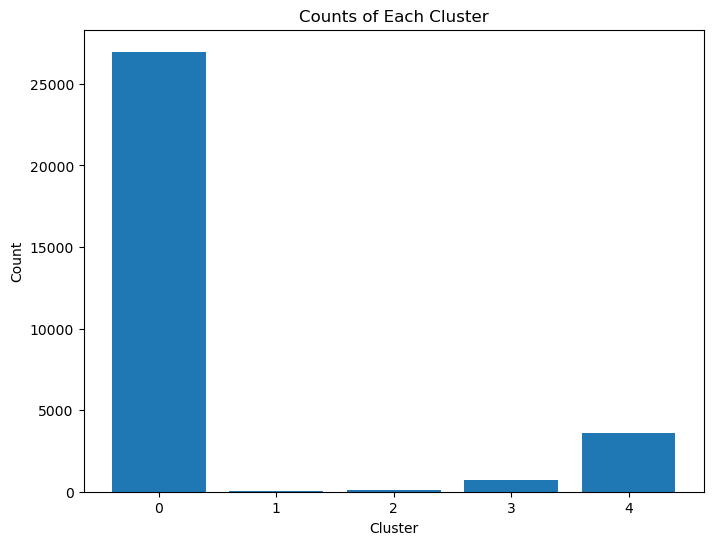

In [16]:
import matplotlib.pyplot as plt

# Group by 'cluster' and calculate the count
grouped = prediction.groupBy("cluster").count().orderBy("cluster").toPandas()

# Plot the counts
plt.figure(figsize=(8, 6))
plt.bar(grouped["cluster"], grouped["count"])
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Counts of Each Cluster")
plt.show()


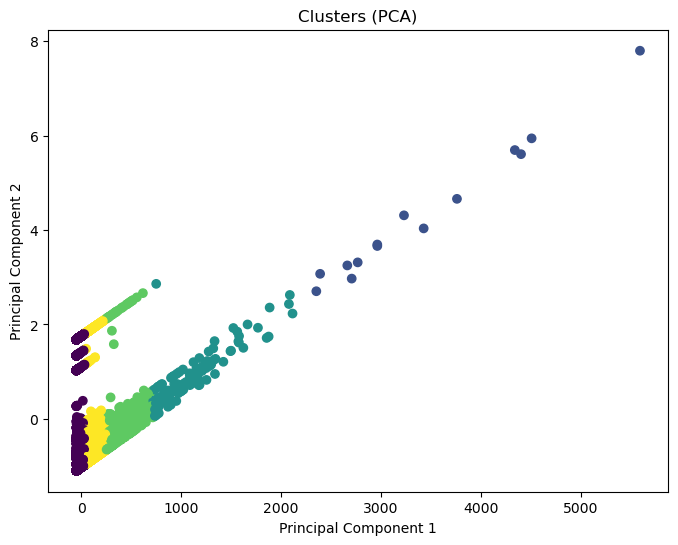

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract the cluster and feature columns from the prediction DataFrame
clusters = prediction.select("cluster").toPandas()["cluster"]
features = prediction.select("features").toPandas()["features"]

# Convert the features to a list of arrays
features_list = [row.toArray() for row in features]

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_list)

# Extract the reduced dimensions
x_values = reduced_features[:, 0]
y_values = reduced_features[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values, c=clusters)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Clusters (PCA)")
plt.show()


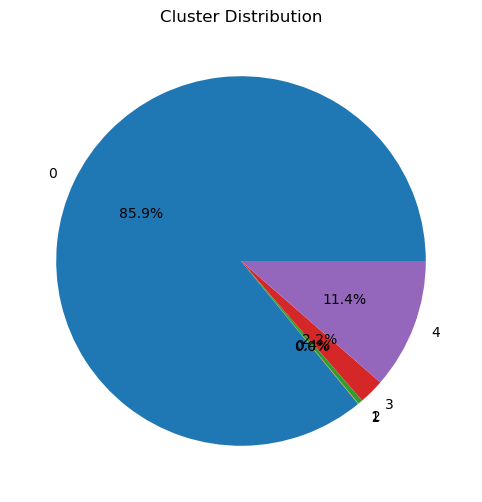

In [20]:
import matplotlib.pyplot as plt

# Group by 'cluster' and calculate the count
grouped = prediction.groupBy("cluster").count().orderBy("cluster").toPandas()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(grouped["count"], labels=grouped["cluster"], autopct='%1.1f%%')
plt.title("Cluster Distribution")
plt.show()
